In [1]:
# Copyright 2023 NASA
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deploying Harmonized Landsat and Sentinel-2 (HLS) Foundational Model to Vertex AI using custom container serving

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/NASA-IMPACT/hls-foundation-vertexai/blob/master/notebooks/IMPACT_SERVIR_HLS_FM_Customer_Container_G4G.ipynb.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/NASA-IMPACT/hls-foundation-vertexai/blob/master/notebooks/IMPACT_SERVIR_HLS_FM_Customer_Container_G4G.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
</table>

This notebook is also available in this github repo: https://github.com/NASA-IMPACT/hls-foundation-vertexai. Navigate to the `notebooks` folder.

## Overview

This tutorial walks you through building a custom container to serve fine-tuned HLS models on Vertex AI. We will be using FastAPI framework to create a prediction and health endpoint, following the conventions required by Vertex AI for custom model deployments. Google Cloud Platform (GCP) code build will be used to build the image used by vertex AI model deployment.

Learn more about [HLS-Foundational-Model](https://github.com/NASA-IMPACT/hls-foundation-os), [Custom training](https://cloud.google.com/vertex-ai/docs/training/custom-training) and [Vertex AI Prediction](https://cloud.google.com/vertex-ai/docs/predictions/get-predictions).

The tutorial makes heavy use of techniques mentioned in this [notebook](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/SDK_Custom_Container_Prediction.ipynb).

### Objective

In this notebook, you learn how to create, deploy and serve a custom foundational model on Vertex AI. This notebook focuses more on deploying the model than on the design of the model itself. For design architecture of the HLS FM Model, check out [here](https://github.com/NASA-IMPACT/hls-foundation-os).


This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Models
- Vertex AI Endpoints

The steps performed include:

- FastAPI server to handle predictions and health checks.
- Push GCP cloud build to build and push artifacts to GCP Artifcat Registry.
- Create Vertex AI Model from the custom image in Artifact Registry.
- Deploy the model to Vertex AI Endpoint for online prediction.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage
* Artifact Registry
* Cloud Build

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), [Artifact Registry pricing](https://cloud.google.com/artifact-registry/pricing) and [Cloud Build pricing](https://cloud.google.com/build/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Define variables for the running the notebook

Start by inputting your cloud project id and the bucket name for storing the artificats when running the notebook.

Note: the bucket name should be unique, so change <user-name> below to your unique `user-name`.

In [2]:
PROJECT_ID = <YOUR-PROJECT-ID>  # @param {type:"string"}

BUCKET_URI = f"gs://<user-name>-hls-intermediate"  # @param {type:"string"}



## Clone the github repo
This repo has all the code needed to deploy the Foundational Model into the Vertex AI.

In [2]:
! git clone https://github.com/nasa-impact/hls-foundation-vertexai.git


Cloning into 'hls-foundation-vertexai'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 193 (delta 98), reused 173 (delta 81), pack-reused 0
Receiving objects: 100% (193/193), 534.98 KiB | 1.70 MiB/s, done.
Resolving deltas: 100% (98/98), done.


### Install VertexAI Python API

In [4]:
!pip install google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1


### The following cell restarts the kernel

In [5]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [3]:
# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [4]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

In [5]:
from google.colab import auth
auth.authenticate_user()

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [10]:
! gsutil mb -l {REGION} {BUCKET_URI}

Creating gs://hls-intermediate/...


## Import libraries

In [6]:
import os

from google.cloud import aiplatform

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [7]:
aiplatform.init(project=PROJECT_ID, location=REGION)

### Configure resource names

Set a name for the following resources:

`MODEL_ARTIFACT_DIR` - Folder directory path to your model artifacts within a Cloud Storage bucket, for example: "my-models/hydrological-forecasting/trial-4"

`REPOSITORY` - Name of the Artifact Repository to create or use.

`IMAGE` - Name of the container image that is pushed to the repository.

`MODEL_DISPLAY_NAME` - Display name of Vertex AI Model resource.

In [8]:
MODEL_ARTIFACT_DIR = "model-artifact"  # @param {type:"string"}
REPOSITORY = "artifact-repo"  # @param {type:"string"}
IMAGE = "container-image"  # @param {type:"string"}
MODEL_DISPLAY_NAME = "hls-model"  # @param {type:"string"}

# Set the defaults if no names were specified
if MODEL_ARTIFACT_DIR == "[your-artifact-directory]":
    MODEL_ARTIFACT_DIR = "custom-container-prediction-model"

if REPOSITORY == "[your-repository-name]":
    REPOSITORY = "custom-container-prediction"

if IMAGE == "[your-image-name]":
    IMAGE = "fm-fastapi-server"

if MODEL_DISPLAY_NAME == "[your-model-display-name]":
    MODEL_DISPLAY_NAME = "fm-custom-container"

### Upload model artifacts and custom code to Cloud Storage

Before you can deploy your model for serving, Vertex AI needs access to the following files in Cloud Storage:

Run the following commands to upload your files:

In [14]:
%cd /content/hls-foundation-vertexai/code/
!ls
!gsutil cp -r * {BUCKET_URI}/{MODEL_ARTIFACT_DIR}/
%cd ..

/content/hls-foundation-vertexai/code
lib  main.py  setup.py
Copying file://lib/__init__.py [Content-Type=text/x-python]...
Copying file://lib/infer.py [Content-Type=text/x-python]...
Copying file://lib/post_process.py [Content-Type=text/x-python]...
Copying file://lib/downloader.py [Content-Type=text/x-python]...
/
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://main.py [Content-Type=text/x-python]...
Copying file://setup.py [Content-Type=text/x-python]...
\
Operation completed over 6 objects/17.9 KiB.                                     
/content/hls-foundation-vertexai


## Build and push container to Artifact Registry

We will use the `Dockerfile` that sets up necessary compute environment, uses the main [HLS Foundation source base](https://github.com/NASA-IMPACT/hls-foundation-os/). This automatically runs FastAPI for you using Uvicorn. Visit [the FastAPI docs to read more about deploying FastAPI with Docker](https://fastapi.tiangolo.com/deployment/docker/) to learn more.

### Build Custom Container


#### Enable Artifact Registry API
You must enable the Artifact Registry API service for your project.

<a href="https://cloud.google.com/artifact-registry/docs/enable-service">Learn more about Enabling service</a>.

In [15]:
! gcloud services enable artifactregistry.googleapis.com

### Create a private Docker repository
Your first step is to create your own Docker repository in Google Artifact Registry.

1 - Run the gcloud artifacts repositories create command to create a new Docker repository with your region with the description "docker repository".

2 - Run the gcloud artifacts repositories list command to verify that your repository was created.

### View the artificats
https://console.cloud.google.com/artifacts/browse/{PROJECT_ID} (replace PROJECT_ID with your project id)

In [9]:
ARTIFACT_REPOSITORY = "hls-model"

! gcloud artifacts repositories create {ARTIFACT_REPOSITORY} --repository-format=docker --location={REGION} --description="Docker repository for HLS FM"

! gcloud artifacts repositories list

Push the image to the created artifact repository using Cloud-Build.

**Note:** The following command automatically considers the Dockerfile from the directory it is being run from.

View the builds
https://console.cloud.google.com/cloud-build/builds;region=us-central1?project={PROJECT_ID}
(replace PROJECT_ID with your project id)

Before we start the build, make sure we are in the right directory.

In [17]:
!pwd

/content/hls-foundation-vertexai


Next, build the docker image using Cloud Build.

In [18]:
!gcloud builds submit --region={REGION} --tag={REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REPOSITORY}/{IMAGE} --gcs-source-staging-dir={BUCKET_URI}/{REPOSITORY} --gcs-log-dir={BUCKET_URI}/{REPOSITORY}_logs

Creating temporary tarball archive of 21 file(s) totalling 1.4 MiB before compression.
Some files were not included in the source upload.

Check the gcloud log [/content/.config/logs/2023.10.06/21.29.02.388550.log] to see which files and the contents of the
default gcloudignore file used (see `$ gcloud topic gcloudignore` to learn
more).

Uploading tarball of [.] to [gs://hls-intermediate/artifact-repo/1696627744.759636-fe400050a3314bbb88f7462936f59ada.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/servir-ee/locations/us-central1/builds/100cf738-aad1-46cb-89f6-5f9ba27f40da].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds;region=us-central1/100cf738-aad1-46cb-89f6-5f9ba27f40da?project=884981013841 ].
 REMOTE BUILD OUTPUT
starting build "100cf738-aad1-46cb-89f6-5f9ba27f40da"

FETCHSOURCE
Fetching storage object: gs://hls-intermediate/artifact-repo/1696627744.759636-fe400050a3314bbb88f7462936f59ada.tgz#1696627747918075
Copying gs://hls-intermediat

## Deploy to Vertex AI

### Create Vertex AI model using artifact uri
Use the Python SDK to upload and deploy your model from the artifact registry.

You can view your Vertex AI models here: https://console.cloud.google.com/vertex-ai/models?project={PROJECT_ID}

In [10]:
model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=f"{BUCKET_URI}/{MODEL_ARTIFACT_DIR}",
    serving_container_image_uri=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REPOSITORY}/{IMAGE}",
)

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/884981013841/locations/us-central1/models/2902664517840273408/operations/76024288393560064


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/884981013841/locations/us-central1/models/2902664517840273408/operations/76024288393560064


Model created. Resource name: projects/884981013841/locations/us-central1/models/2902664517840273408@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/884981013841/locations/us-central1/models/2902664517840273408@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/884981013841/locations/us-central1/models/2902664517840273408@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/884981013841/locations/us-central1/models/2902664517840273408@1')


### Deploy the model to Vertex AI Endpoints

Deploy the model to a Vertex AI Endpoint. After this step completes, the model is deployed and ready for online predictions.

In [11]:
endpoint = model.deploy(machine_type="n1-standard-4", accelerator_type="NVIDIA_TESLA_V100", accelerator_count=1)

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/884981013841/locations/us-central1/endpoints/4067614679654989824/operations/3514522603890933760


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/884981013841/locations/us-central1/endpoints/4067614679654989824/operations/3514522603890933760


Endpoint created. Resource name: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/884981013841/locations/us-central1/endpoints/4067614679654989824')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/884981013841/locations/us-central1/endpoints/4067614679654989824')


Deploying model to Endpoint : projects/884981013841/locations/us-central1/endpoints/4067614679654989824


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/884981013841/locations/us-central1/endpoints/4067614679654989824


Deploy Endpoint model backing LRO: projects/884981013841/locations/us-central1/endpoints/4067614679654989824/operations/4669695908311465984


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/884981013841/locations/us-central1/endpoints/4067614679654989824/operations/4669695908311465984


Endpoint model deployed. Resource name: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


## Request predictions

Send online requests to the model deployed to the endpoint and get predictions.

### 1. Using Python SDK


Get predictions from the endpoint for a sample input using python SDK.

In [ ]:
endpoint.predict(instances=[
    {
      "date": "2023-08-13",
      "bounding_box": [
        -156.81605703476012,
        20.69675592885614,
        -156.41605703476014,
        21.096755928856137
      ],
      "model_id": "burn_scars"
    }
  ])

### 2. Using REST

Get predictions from the endpoint using curl request.

In [13]:
ENDPOINT_ID = endpoint.name

In [14]:
ENDPOINT_ID

'4067614679654989824'

In [15]:
%%writefile test.json

{
  "instances": [
    {
      "date": "2023-08-13",
      "bounding_box": [
        -156.81605703476012,
        20.69675592885614,
        -156.41605703476014,
        21.096755928856137
      ],
      "model_id": "burn_scars"
    }
  ]
}

Writing test.json


In [17]:
# Get inference from the deployed endpoint. Copy over the endpoint id from above and replace <ENDPOINT_ID>, and project id from about to replace <PROJECT_ID>
# Get inference from the deployed endpoint.
!curl -X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
https://us-central1-aiplatform.googleapis.com/v1/projects/$PROJECT_ID/locations/us-central1/endpoints/$ENDPOINT_ID:predict \
-d "@test.json"

### 3. Using gcloud CLI

Get predictions from the endpoint using gcloud CLI.

In [18]:
!gcloud ai endpoints predict $ENDPOINT_ID \
  --region=$REGION \
  --json-request=test.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'features': [{'geometry': {'coordinates': [[[-156.79978669506, 21.05582347739082], [-156.8011274594037, 21.05297260326473], [-156.8038651214952, 21.05171323433952], [-156.8072109599764, 21.05122640603662], [-156.8105901345874, 21.05154160178293], [-156.8116934122266, 21.04890552137409], [-156.8103590652319, 21.04605773316475], [-156.8134168534644, 21.04504919724074], [-156.8167798095499, 21.04460745917352], [-156.819764741655, 21.04614182231752], [-156.8229375176576, 21.04505552657012], [-156.8261486470155, 21.04420113083023], [-156.8264192769006, 21.04333100375765], [-156.823800389993, 21.04333100375765], [-156.819323545988, 21.04333100375765], [-156.8139335304865, 21.04333100375765], [-156.8085751291252, 21.04333100375765], [-156.8041931274961, 21.04333100375765], [-156.8017323112092, 21.04333100375765], [-156.8023455685239, 21.0454792965308], [-156.8022829629914, 21.04803209374421], [-156.7989653420935, 21.

### 4. Testing using Vertex AI interface

1. Go to the vertex AI UI Page at https://console.cloud.google.com/vertex-ai?project={YOUR_PROJECT}
2. Click on `Model Registry` to view your deployed model.
3. Click on your model link, and then click `DEPLOY & TEST` tab.
4. In the `JSON request` of the `Test your model`, use the following JSON value

```
{
  "instances": [
    {
      "date": "2023-08-13",
      "bounding_box": [
        -156.81605703476012,
        20.69675592885614,
        -156.41605703476014,
        21.096755928856137
      ],
      "model_id": "burn_scars"
    }
  ]
}
```

The `Response` box would show your response.

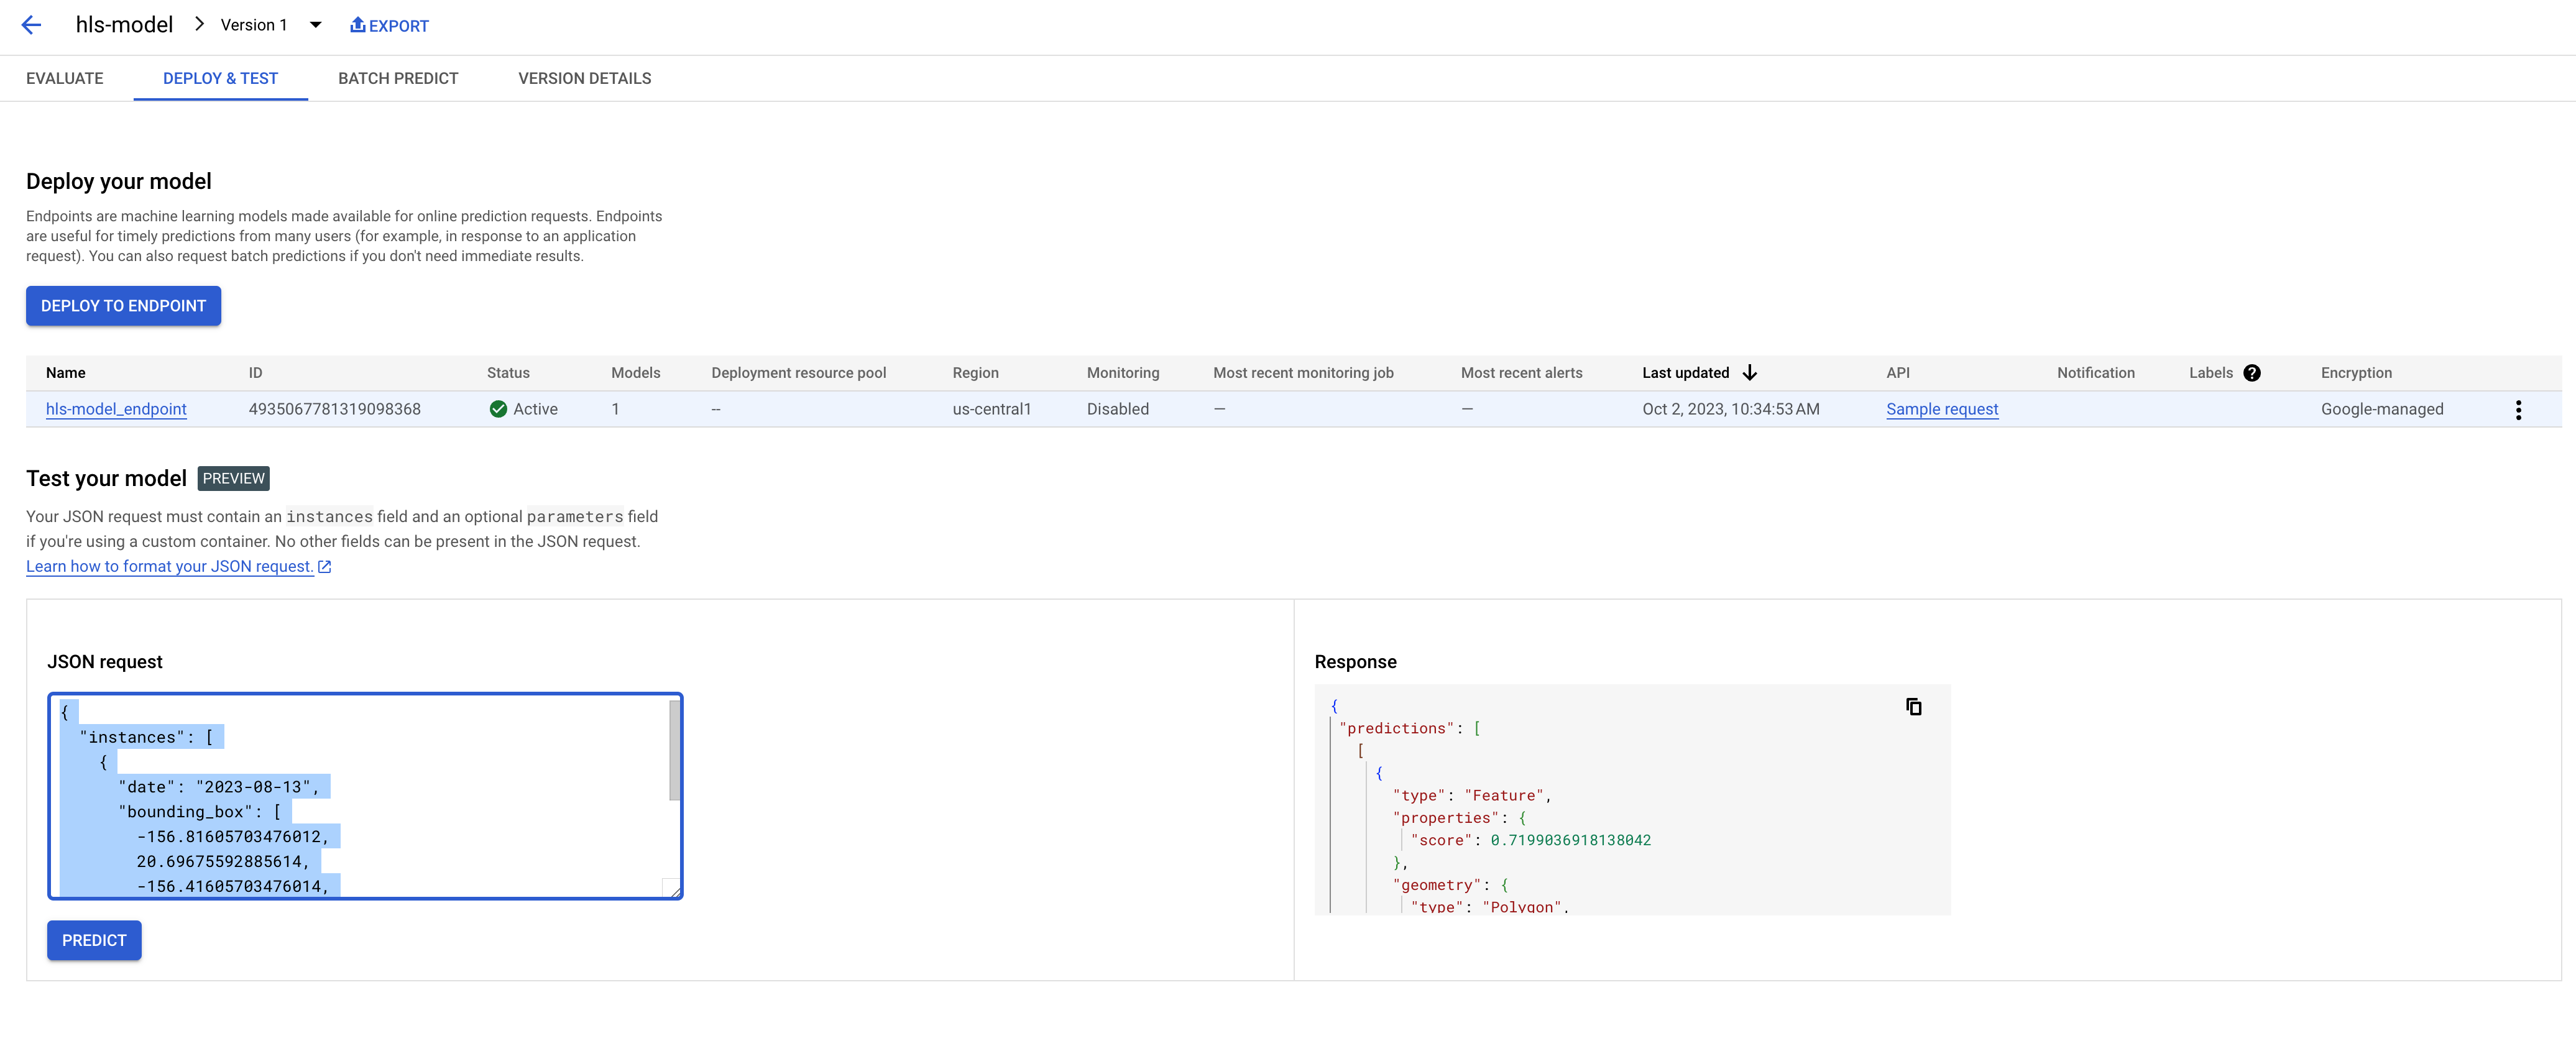

## Bonus: Linking the Foundational Model prediction to Earth Engine

For this notebook, NASA-IMPACT has graciously hosted their model in Vertex AI for us. Below we will be making use of this and looking at ways to integrate it into the Earth Engine.

### Import Libraries

In [19]:
import json
import requests
import ee
from geemap import geemap

### Authenticate and initialize Earth Engine

You will need to create a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. You can find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [20]:
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=73vUu77jS5YiIgFxz6Yt3kPCIxJ4qty0sUOtjdqjxqA&tc=6tC5wSC49GpQSsA0b3VM8bdC9fD5z29abF1x-a6nvOA&cc=hWIJOGYOx1v8JuaqqdQyexVhQbM-D0mpDl48FZwmjJs

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXlarfYYu9SkVGNVQsEgq0FcfclXyOV5i90vlkym0cpZQ45IG31-cLM

Successfully saved authorization token.


### Make API call to the Vertex AI endpoint programtically.

This will make a post request to the inference gateway API URL hosted by NASA IMPACT. The data is sent along the requests.

If you get timeout error, try one more time.

In [21]:
# URL endpoint
url = "https://hls-foundation-model-infer-c0tpnz6z.uc.gateway.dev/infer"

# Request headers
headers = {
    "Content-Type": "application/json"
}

# Request payload/data
data = {
    "date": "2023-08-13",
    "bounding_box": [-156.81605703476012, 20.69675592885614, -156.51605703476014, 20.996755928856137],
    "model_id": "burn_scars"
}

# Making the POST request
response = requests.post(url, headers=headers, json=data, timeout=70)

# Printing the response (optional)
print(response.text)


{"body":[[{"features":[{"geometry":{"coordinates":[[[-156.6456398845894,21.01801224065882],[-156.6483325200917,21.01610642899932],[-156.6505380758236,21.01389569982275],[-156.653713102061,21.01256378692599],[-156.6575586508229,21.01274942993498],[-156.6600522334743,21.01032851749051],[-156.6616555059356,21.00767819949041],[-156.6651283223872,21.00851552729118],[-156.6662549228872,21.01137058711216],[-156.6687209639107,21.01156914289043],[-156.6696366568345,21.00841241116231],[-156.6708409820613,21.00536603433759],[-156.6708278507759,21.00202897377209],[-156.6680681584093,21.00061662206506],[-156.6655836806415,21.00312595674956],[-156.6623647512748,21.00482965276645],[-156.6600992323957,21.00732293275899],[-156.6569478720499,21.00747785139378],[-156.6532075165108,21.00743199163846],[-156.6499560020238,21.00890581125373],[-156.6489781680504,21.01208473395023],[-156.6458165786873,21.01379365681024],[-156.6425193754897,21.0132928483031],[-156.6407872534001,21.01593631813706],[-156.64358371

### Load the response

We will next load the response and extract the GeoJson Featurecollection from it.

In [22]:
# Load the response into a Python dictionary
response_data = json.loads(response.text)

# Extracting the features
features = response_data["body"][0][0]

features

{'features': [{'geometry': {'coordinates': [[[-156.6456398845894,
       21.01801224065882],
      [-156.6483325200917, 21.01610642899932],
      [-156.6505380758236, 21.01389569982275],
      [-156.653713102061, 21.01256378692599],
      [-156.6575586508229, 21.01274942993498],
      [-156.6600522334743, 21.01032851749051],
      [-156.6616555059356, 21.00767819949041],
      [-156.6651283223872, 21.00851552729118],
      [-156.6662549228872, 21.01137058711216],
      [-156.6687209639107, 21.01156914289043],
      [-156.6696366568345, 21.00841241116231],
      [-156.6708409820613, 21.00536603433759],
      [-156.6708278507759, 21.00202897377209],
      [-156.6680681584093, 21.00061662206506],
      [-156.6655836806415, 21.00312595674956],
      [-156.6623647512748, 21.00482965276645],
      [-156.6600992323957, 21.00732293275899],
      [-156.6569478720499, 21.00747785139378],
      [-156.6532075165108, 21.00743199163846],
      [-156.6499560020238, 21.00890581125373],
      [-156.648

### Use it in Earth Engine

For this exercise, we will show how to convert those GeoJson to `ee.FeatureCollection` and add them to the map. Depending on your problem, you can use the `FeatureCollection` in your analysis. If you notice carefully, you will also see `score` properties in each polygon feature which is probability value given by the model.

In [23]:
feature_col = ee.FeatureCollection(features)

Map = geemap.Map()
style = {"color": "000000ff", "width": 1, "lineType": "solid", "fillColor": "0000ff40"}

Map.addLayer(feature_col.style(**style), {}, "Polygons")
Map.centerObject(feature_col, 11)
Map

Map(center=[20.953867373814905, -156.61782642101173], controls=(WidgetControl(options=['position', 'transparen…

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Model
- Endpoint
- Artifact Registry Image
- Artifact Repository: Set `delete_art_repo` to **True** to delete the repository created in this tutorial.
- Cloud Storage bucket: Set `delete_bucket` to **True** to delete the Cloud Storage bucket used in this tutorial.

In [24]:
delete_bucket = True
delete_art_repo = True

# Undeploy model and delete endpoint
endpoint.undeploy_all()
endpoint.delete()

# # Delete the model resource
model.delete()

# Delete the container image from Artifact Registry
!gcloud artifacts docker images delete \
    --quiet \
    --delete-tags \
    {REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REPOSITORY}/{IMAGE}

# Delete the artifact registry
if delete_art_repo:
    ! gcloud artifacts repositories delete {ARTIFACT_REPOSITORY} --location=$REGION -q

# Delete the Cloud Storage bucket
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI

Undeploying Endpoint model: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


Undeploy Endpoint model backing LRO: projects/884981013841/locations/us-central1/endpoints/4067614679654989824/operations/6431447787543461888


INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/884981013841/locations/us-central1/endpoints/4067614679654989824/operations/6431447787543461888


Endpoint model undeployed. Resource name: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


Deleting Endpoint : projects/884981013841/locations/us-central1/endpoints/4067614679654989824


INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/884981013841/locations/us-central1/endpoints/4067614679654989824


Delete Endpoint  backing LRO: projects/884981013841/locations/us-central1/operations/8431046022095962112


INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/884981013841/locations/us-central1/operations/8431046022095962112


Endpoint deleted. . Resource name: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/884981013841/locations/us-central1/endpoints/4067614679654989824


Deleting Model : projects/884981013841/locations/us-central1/models/2902664517840273408


INFO:google.cloud.aiplatform.base:Deleting Model : projects/884981013841/locations/us-central1/models/2902664517840273408


Delete Model  backing LRO: projects/884981013841/locations/us-central1/operations/6107188614372786176


INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/884981013841/locations/us-central1/operations/6107188614372786176


Model deleted. . Resource name: projects/884981013841/locations/us-central1/models/2902664517840273408


INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/884981013841/locations/us-central1/models/2902664517840273408


Delete request issued.
Delete request issued for: [hls-model]
Deleted repository [hls-model].
Removing gs://hls-intermediate/artifact-repo/1696627744.759636-fe400050a3314bbb88f7462936f59ada.tgz#1696627747918075...
Removing gs://hls-intermediate/artifact-repo_logs/log-100cf738-aad1-46cb-89f6-5f9ba27f40da.txt#1696628540939344...
Removing gs://hls-intermediate/model-artifact/lib/downloader.py#1696627704916492...
Removing gs://hls-intermediate/model-artifact/lib/infer.py#1696627702514179...
Removing gs://hls-intermediate/model-artifact/lib/post_process.py#1696627703717982...
Removing gs://hls-intermediate/model-artifact/lib/__init__.py#1696627701313447...
Removing gs://hls-intermediate/model-artifact/main.py#1696627706121673...
Removing gs://hls-intermediate/model-artifact/setup.py#1696627707318136...
/ [8/8 objects] 100% Done                                                       
Operation completed over 8 objects.                                              
Removing gs://hls-intermedia